# Visual and Data Analysis - FIFA 19 Players
- **Created by Andrés Segura Tinoco**
- **Created on May 1, 2019**

# 4. Clustering Data
## Loading main libraries and data

In [1]:
# Load the Pandas libraries
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
# Load scikit-learn library for K-Means
from sklearn.cluster import KMeans

In [3]:
# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load Interact libraries
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [5]:
# Read FIFA 19 players data only using the current skill values
dataURL = "https://raw.githubusercontent.com/ansegura7/DataScience_FIFA19Data/master/data/fifa19_overall_data.csv"
rawdata = pd.read_csv(dataURL)

In [6]:
# Loading FIFA 19 positions dataset
dataURL = "https://raw.githubusercontent.com/ansegura7/DataScience_FIFA19Data/master/data/fifa19_positions.csv"
positions = pd.read_csv(dataURL)

In [7]:
# Function that obtains the numerical data from the data frame
def getNumericalData(data, quality):
    numData = pd.DataFrame()
    
    # Create DataFrame
    for col in data.columns:
        if (str(data[col].dtype) != "object"):
            numData[col] = data[col]
    
    # Remove columns that are not relevant for the analysis
    nonColumns = ["Order", "ID", "Overall", "Potential", "Value €", "Wage €", "Release Clause €"]
    numData = numData.drop(nonColumns, axis=1)
    
    # Data Quality process
    if(quality and len(numData.columns) > 0):
        numData = numData.fillna(numData.mean())
    
    print(numData.shape)
    return numData;

In [8]:
# Set a Overall threshold
threshold = rawdata.Overall.median()
threshold

66.0

In [9]:
# Filter/Delete player with an overall below the threshold
rawdata = rawdata.loc[rawdata["Overall"] >= threshold]
len(rawdata)

9927

In [10]:
numData = getNumericalData(rawdata, True)
numData.head()

(9927, 68)


,Age,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,HeightMts,WeightLbs,LS,ST,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,2202,5.0,4.0,4.0,10.0,1.70,159.0,88,88,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,2228,5.0,4.0,5.0,7.0,1.88,183.0,91,91,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,2143,5.0,5.0,5.0,10.0,1.75,150.0,84,84,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,1471,4.0,3.0,1.0,1.0,1.93,168.0,0,0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,2281,4.0,5.0,4.0,7.0,1.80,154.0,82,82,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


## Apply PCA with Standardization

In [11]:
# Function that apply Principal Component Analysis
def applyPCA(data, std):
    
    # Standardize the Data
    if std == True:
        x = StandardScaler().fit_transform(data.values)
    else:
        x = data.values
    
    # Create a DataFrame from PCA
    pca = PCA(n_components = 2)
    pcaData = pca.fit_transform(x)
    pcaDF = pd.DataFrame(data = pcaData, columns = ["PC1", "PC2"])
    
    # Show the total explained variance ratio of model
    print(sum(pca.explained_variance_ratio_) * 100)
    
    return pcaDF;

In [12]:
# Function that replace the player position by the zone
def replacePositionByZone(data):
    
    for ix in range(len(positions)):
        data["Position"] = data["Position"].replace(positions.Position[ix], positions.Zone[ix])
    
    return data;

In [13]:
# Apply the PCA algorithm
pcaDF = applyPCA(numData, False)

# Create the PCA data
pcaDF = pd.concat([pcaDF, rawdata[["Position"]]], axis = 1)
pcaDF = pcaDF[pcaDF["PC1"].notnull()]
pcaDF = replacePositionByZone(pcaDF)
pcaDF.head()

94.54305758140961


,PC1,PC2,Position
0,-501.986873,-142.947644,Attack
1,-522.280000,-126.231241,Attack
2,-441.905694,-127.713563,Midfield
3,370.664895,-106.945268,GoalKeper
4,-581.017785,-68.727994,Midfield


## Clustering: K-Means

In [14]:
# Getting the values and plotting it
x = pcaDF['PC1'].values
y = pcaDF['PC2'].values
train = np.array(list(zip(x, y)))

In [15]:
# Calculating the Jambu Elbow
Nc = range(1, 20)
kmeans = [KMeans(n_clusters = i) for i in Nc]
score = [kmeans[i].fit(train).score(train) for i in range(len(kmeans))]

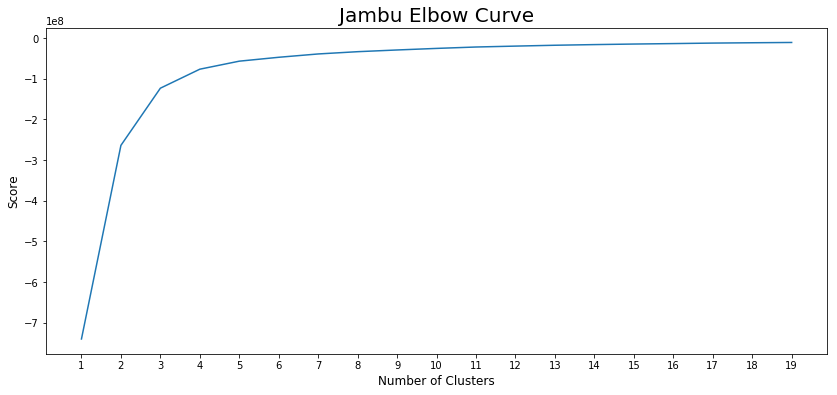

In [16]:
# Plot the results
fig, ax0 = plt.subplots(figsize = (14, 6))
plt.plot(Nc, score)
plt.xticks(np.arange(1, 20, 1))
plt.xlabel("Number of Clusters", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.title("Jambu Elbow Curve", fontsize = 20)
plt.show()

### Compare results with K-means grouping

In [17]:
# Calculates the K-Means for (x, y) dataset
def runKMeans(k_clusters):
    kmeans = KMeans(n_clusters = k_clusters, algorithm = "elkan")
    kmeans = kmeans.fit(train)

    # Getting the cluster labels
    clusters = kmeans.predict(train)
    
    # Centroid values
    centroids = kmeans.cluster_centers_
    
    # Plotting K-Means result
    plotKMeansData(train, k_clusters, centroids, clusters)

In [18]:
# Create scatter plot with K-Means data
def plotKMeansData(data, k_clusters, centroids, clusters):
    fig, ax1 = plt.subplots(figsize = (14, 14))
    
    # Plotting vars
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    nData = len(data)
    
    # Create scatter plot
    for i in range(k_clusters):
        points = np.array([data[j] for j in range(nData) if clusters[j] == i])
        sns.scatterplot(ax = ax1, x = points[:, 0], y = points[:, 1], size = 5, color = colors[i])
    plt.scatter(centroids[:, 0], centroids[:, 1], s = 20, color = "black", marker = "D")
    
    # Plot setup
    ax1.set_xlabel("PC 1", fontsize = 12)
    ax1.set_ylabel("PC 2", fontsize = 12)
    ax1.set_title("Players by Zones", fontsize = 20)
    ax1.legend(["K-Means: Players with overall >= " + str(threshold)])
    ax1.grid()

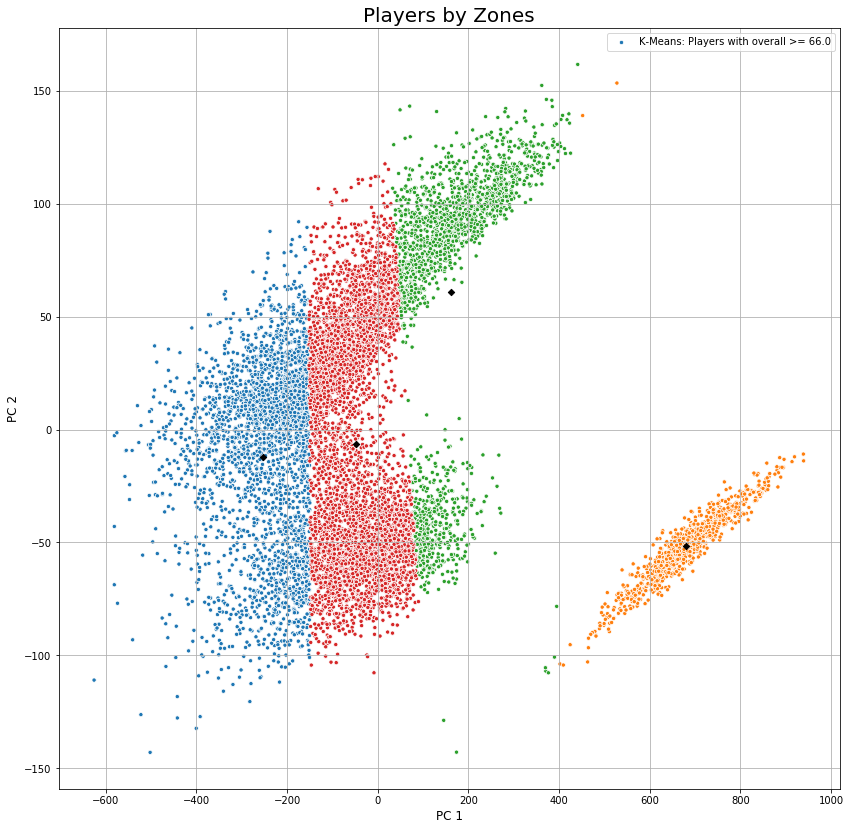

In [19]:
# Create interactive control to control k value
# interactive(runKMeans, k_clusters = widgets.IntSlider(min = 1, max = 7, step = 1, value = 4))
runKMeans(k_clusters = 4)

### Compare results with natural grouping

In [20]:
# Palette by positions dictionary
posPalette = dict()
posPalette["GoalKeper"] = "#dc3912"
posPalette["Defense"] = "#3366cc"
posPalette["Midfield"] = "#ff9900"
posPalette["Attack"] = "#109618"

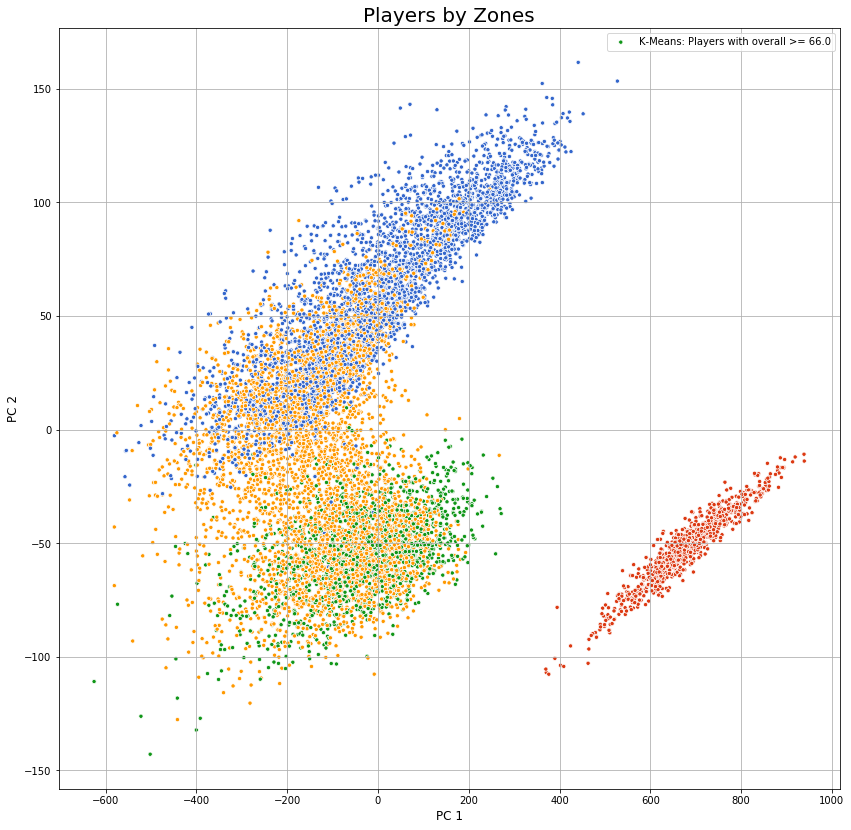

In [21]:
# Create scatter plot with players label
fig, ax2 = plt.subplots(figsize = (14, 14))

# Create 2D scatter plot
plot = sns.scatterplot(ax = ax2, data = pcaDF, x = "PC1", y = "PC2", hue = "Position", size = 5, palette = posPalette)

# Plot setup
ax2.set_xlabel("PC 1", fontsize = 12)
ax2.set_ylabel("PC 2", fontsize = 12)
ax2.set_title("Players by Zones", fontsize = 20)
ax2.legend(["K-Means: Players with overall >= " + str(threshold)])
ax2.grid()

---
<a href="https://github.com/ansegura7/DataScience_FIFA19Data">&laquo; GitHub Repository</a>